In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import os

In [2]:
def plot_high_light(label):
    label_start = np.where(np.diff(label) == 1)[0]
    label_end = np.where(np.diff(label) == -1)[0]
    label_start, label_end = check_consistent(label_start, label_end, len(label))
    return label_start, label_end


def check_consistent(start, end, total_len):
    if len(start) != len(end):
        if len(start) > 0:
            end = [total_len]
        elif len(end) > 0:
            start = [0]
    return start, end


def plot_data_ax(data, ax, labels=None, dr=0.5):
    color_list = ["yellow", 'royalblue']
    n_samples, n_rows = data.shape[1], data.shape[0]
    y_tick_offsets = (np.arange(n_rows) * dr)[::-1]
    eeg_data = data + y_tick_offsets[:, np.newaxis]
    time_domain = np.repeat(np.arange(data.shape[1])[:, np.newaxis] / 249, 4, 1)
    ax.plot(time_domain, eeg_data.T, 'k', linewidth=0.5)
    if labels is not None:
        for j, label in enumerate(labels):
            label_start, label_end = plot_high_light(label)
            if len(label_start) > 0:
                for i in range(len(label_start)):
                    ax.axvspan(label_start[i] / 249, label_end[i] / 249, color=color_list[j], alpha=0.3)

    ax.set_yticks(eeg_data.mean(1))
    ax.set_yticklabels(["Ch1", "Ch2", "Ch3", "Ch4"])
    ax.grid(axis='x')
    ax.set_xlabel('Time (s)')


def combine_window_to_episode(data, seq_len, index=None):
    cum_sum_index = np.cumsum(seq_len)
    cum_sum_index = np.insert(cum_sum_index, 0, 0)

    assert len(data) == cum_sum_index[-1]

    data_out = [None] * (len(cum_sum_index) - 1)

    for i in range(1, len(cum_sum_index)):
        start_index, end_index = cum_sum_index[i - 1], cum_sum_index[i]
        episode_data = data[start_index:end_index]

        if index is None:
            out = episode_data
        else:
            episode_labeled = index[start_index:end_index]
            out = episode_data[episode_labeled]

        if len(out) > 0:
            data_out[i - 1] = out

    data_out = [segment for segment in data_out if segment is not None]

    return np.array(data_out, dtype=object)


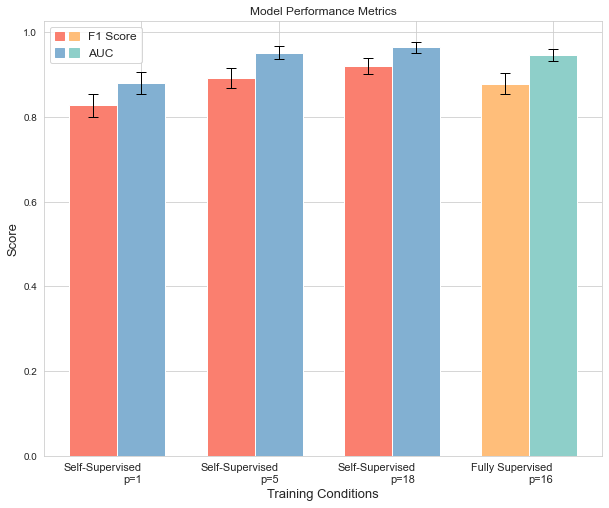

In [3]:
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple


# Data extracted from the table
categories = [
    "Self-Supervised\np=1",
    "Self-Supervised\np=5",
    "Self-Supervised\np=18",
    "Fully Supervised\np=16"
]

metrics = [
    "Accuracy", "Macro F1 score", "AUC", "Accuracy (within episode)", "Macro F1 score (within episode)"
]

metrics = [
 "Macro F1 score", "AUC"
]

# Values and error bars
data = {
    # "Accuracy": [(0.8567, 0.0227), (0.9087, 0.0198), (0.9327, 0.0157), (0.8933, 0.0216)],
    "Macro F1 score": [(0.8280, 0.0275), (0.8933, 0.0234), (0.9209, 0.0191), (0.8786, 0.0249)],
    "AUC": [(0.8809, 0.0264), (0.9518, 0.0154), (0.9645, 0.0138), (0.9474, 0.0143)],
    # "Accuracy (within episode)": [(0.7714, 0.0429), (0.8850, 0.0641), (0.9123, 0.0344), (0.8477, 0.0581)],
    # "Macro F1 score (within episode)": [(0.7324, 0.0531), (0.8469, 0.0780), (0.9039, 0.0405), (0.8299, 0.0618)]
}

# Combined plotting with error bars
fig, ax = plt.subplots(figsize=(10, 8))

x = np.arange(len(categories))
width = 0.35  # the width of the bars

color_list = ['#fa7f6f',  '#82b0d2','#fa7f6f',  '#82b0d2','#fa7f6f',  '#82b0d2', '#FFBE7A','#8ECFC9' ]

# Plotting each metric with error bars
for i, metric in enumerate(metrics):
    values = [data[metric][j][0] for j in range(len(categories))]
    errors = [data[metric][j][1] for j in range(len(categories))]
    # print(list(sns.color_palette("Paired").as_hex())[i::2])
    ax.bar(x + i*width, values, width, yerr=errors, capsize=5, label=metric, error_kw=dict(lw=1, capsize=5, capthick=1), color = color_list[i::2])
    

legend_elements = [Patch(facecolor='gold', edgecolor='gold', label='interictal'),
                   Patch(facecolor='royalblue', edgecolor='royalblue', label='ictal')]

legend_elements = [
    (Patch(facecolor='#fa7f6f', edgecolor='#fa7f6f'), Patch(facecolor='#FFBE7A', edgecolor='#FFBE7A')),
    (Patch(facecolor='#82b0d2', edgecolor='#82b0d2'), Patch(facecolor='#8ECFC9', edgecolor='#8ECFC9'))
]

# Labels for the legend elements
labels = ['F1 Score', 'AUC']
# Add legend to plot
# plt.legend(handles=legend_elements, fontsize=11)

# Adding labels and titles
ax.set_xlabel('Training Conditions', fontsize=13)
ax.set_ylabel('Score', fontsize=13)
ax.set_title('Model Performance Metrics')
ax.set_xticks(x + width, fontsize=11)
ax.set_xticklabels(categories, fontsize=11)
ax.legend(legend_elements, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper left',fontsize=12)
ax.grid('x')
plt.xticks(rotation=0, ha='right')
plt.savefig("BarPlot.svg", format="svg")
plt.show()

## Active Learning Plot

In [19]:
active_learning_data = np.load('active_learning_curve_full.npy', allow_pickle=True).item()

In [17]:
active_learning_data

{'BadgeSampling':    Number_of_Annotation  Length_of_Annotation_hours  \
 0                     9                    0.216389   
 1                    29                    0.696389   
 2                    53                    1.184444   
 3                    76                    1.664722   
 4                   100                    2.141667   
 5                   122                    2.618333   
 6                   145                    3.112222   
 7                   171                    3.600833   
 
                                      Accuracy  \
 0  (0.8440699075557654, 0.015232724430677608)   
 1  (0.8958965620556423, 0.011505557925835751)   
 2  (0.9201537060380945, 0.010129729741821046)   
 3  (0.9335635803888014, 0.010049620004382306)   
 4   (0.9304444666722236, 0.01188840350836495)   
 5  (0.9358571440220494, 0.012722018782419646)   
 6  (0.9427797486254861, 0.009368739445763276)   
 7  (0.9461260346950467, 0.008342458377869656)   
 
                         

In [28]:
import matplotlib
matplotlib.use('cairo')

In [10]:
import seaborn as sns
sns.color_palette().as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

BadgeSampling
0    (0.7696228874601078, 0.022942958167734125)
1    (0.8515206355310667, 0.014898703017009601)
2     (0.8908027348600869, 0.01421558643011598)
3    (0.9117180553932728, 0.012765996896467102)
4    (0.9082560589339697, 0.015026519816294548)
5      (0.915621331820317, 0.01565488992140679)
6    (0.9235966883623087, 0.012265698523383254)
7    (0.9275739850416509, 0.010822828313960859)
Name: F1_score, dtype: object
0      9
1     29
2     53
3     76
4    100
5    122
6    145
7    171
Name: Number_of_Annotation, dtype: int64
EntropySampling
0      (0.7413761166493167, 0.02238023811562212)
1     (0.8675166862932715, 0.017131133900076027)
2      (0.8624210206015038, 0.01693286211443598)
3     (0.9027509431091382, 0.014882138938612665)
4      (0.903862313971606, 0.013451721189096546)
5     (0.9120272662299389, 0.013024755164534519)
6     (0.9145771713079862, 0.016476482536242336)
7     (0.9288822082284004, 0.010842975132864256)
8     (0.9241591998194675, 0.012038587241639193)
9 

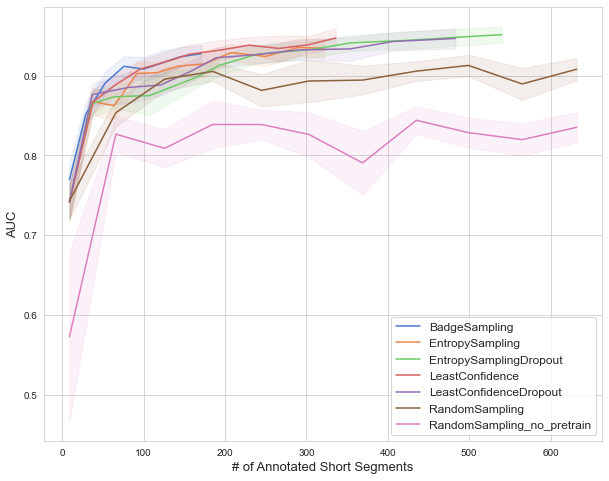

In [16]:
import matplotlib.font_manager as fm
plt.figure(figsize=(10, 8))
active_learning_curve = {}

for i, key in enumerate(active_learning_data.keys()):
    print(key)
    data_df = active_learning_data[key]
    metric = data_df.F1_score #data_df.f1_score
    print(metric)
    n_sample = data_df.Number_of_Annotation #data_df.Length_of_Annotation_hours
    print(n_sample)
    accuracies, stds = zip(*metric)
    iterations = range(1, len(accuracies) + 1)
    
    plt.plot(n_sample, accuracies, label=key, color=list(sns.color_palette("muted").as_hex())[i])
    plt.fill_between(n_sample, 
                     [a - s for a, s in zip(accuracies, stds)], 
                     [a + s for a, s in zip(accuracies, stds)], 
                     color=list(sns.color_palette("muted").as_hex())[i], alpha=0.1)
    
plt.xlabel('# of Annotated Short Segments', fontsize=13)
plt.ylabel('AUC', fontsize=13)
# plt.title('Accuracy vs Number of Annotated Segments in RNS data')
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("AUCCurve.svg", format="svg")
plt.show()

In [37]:
# import matplotlib.font_manager as fm
plt.figure(figsize=(10, 8))
active_learning_curve = pd.DataFrame()

def fill_missing_values(input_list):
    desired_length = 11
    current_length = len(input_list)
    
    # Convert the list to a NumPy array
    input_array = np.array(input_list, dtype=float)
    
    # If the list is shorter than the desired length, pad with NaN values
    if current_length < desired_length:
        input_array = np.pad(input_array, (0, desired_length - current_length), constant_values=np.nan)
    
    return input_array

for i, key in enumerate(active_learning_data.keys()):
    print(key)
    data_df = active_learning_data[key]
    metric = data_df.F1_score #data_df.f1_score
    n_sample = data_df.Number_of_Annotation #data_df.Length_of_Annotation_hours
    print(n_sample)
    accuracies, stds = zip(*metric)
    print(accuracies)
    # iterations = range(1, len(accuracies) + 1)
    active_learning_curve[str(key)+"_n_sample"] = fill_missing_values(n_sample)
    active_learning_curve[str(key)+"_acc"] =  fill_missing_values(np.around(list(accuracies),4))
    active_learning_curve[str(key)+"_std"] = fill_missing_values(np.around(list(stds),3))
    # active_learning_curve[key] = cell
    

BadgeSampling
0      9
1     29
2     53
3     76
4    100
5    122
6    145
7    171
Name: Number_of_Annotation, dtype: int64
(0.7696228874601078, 0.8515206355310667, 0.8908027348600869, 0.9117180553932728, 0.9082560589339697, 0.915621331820317, 0.9235966883623087, 0.9275739850416509)
BALDDropout
0       9
1      87
2     150
3     225
4     254
5     300
6     384
7     454
8     518
9     587
10    671
Name: Number_of_Annotation, dtype: int32
(0.7427639931042705, 0.8852798059601777, 0.4233534894530418, 0.8757065540094201, 0.879895666073581, 0.4195524602826532, 0.8947681142026361, 0.8871769897364099, 0.8776687696216451, 0.903746337663556, 0.4122926738788892)
EntropySampling
0       9
1      37
2      64
3      92
4     117
5     143
6     175
7     207
8     250
9     290
10    322
Name: Number_of_Annotation, dtype: int64
(0.7413761166493167, 0.8675166862932715, 0.8624210206015038, 0.9027509431091382, 0.903862313971606, 0.9120272662299389, 0.9145771713079862, 0.9288822082284004, 0.92

<Figure size 720x576 with 0 Axes>

In [41]:
active_learning_curve.columns

Index(['BadgeSampling_n_sample', 'BadgeSampling_acc', 'BadgeSampling_std',
       'BALDDropout_n_sample', 'BALDDropout_acc', 'BALDDropout_std',
       'EntropySampling_n_sample', 'EntropySampling_acc',
       'EntropySampling_std', 'EntropySamplingDropout_n_sample',
       'EntropySamplingDropout_acc', 'EntropySamplingDropout_std',
       'KCenterGreedyPCA_n_sample', 'KCenterGreedyPCA_acc',
       'KCenterGreedyPCA_std', 'KMeansSampling_n_sample', 'KMeansSampling_acc',
       'KMeansSampling_std', 'LeastConfidence_n_sample', 'LeastConfidence_acc',
       'LeastConfidence_std', 'LeastConfidenceDropout_n_sample',
       'LeastConfidenceDropout_acc', 'LeastConfidenceDropout_std',
       'LossPredictionLoss_n_sample', 'LossPredictionLoss_acc',
       'LossPredictionLoss_std', 'MarginSamplingDropout_n_sample',
       'MarginSamplingDropout_acc', 'MarginSamplingDropout_std',
       'MeanSTD_n_sample', 'MeanSTD_acc', 'MeanSTD_std',
       'RandomSampling_n_sample', 'RandomSampling_acc', 'Rand

## Embedding Space Plot

### Heatmap

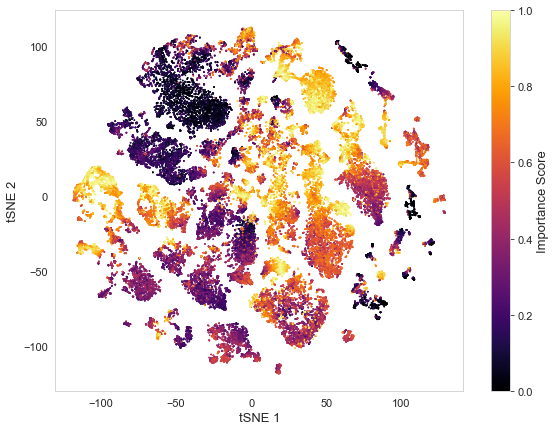

In [4]:
embedding_space_data = pd.read_csv('embedding_space_metrics.csv')
embedding_space_data.importance_score+=1
# import seaborn as sns
# cmap=sns.color_palette("magma", as_cmap=True)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embedding_space_data.comp_1,embedding_space_data.comp_2,c=embedding_space_data.importance_score,cmap='inferno',s=0.5)
cbar = plt.colorbar(scatter)
cbar.set_label('Importance Score', fontsize=13)
cbar.ax.tick_params(labelsize=11)
# plt.title('Swav Embedding t-SNE')
plt.xlabel('tSNE 1', fontsize=13)
plt.ylabel("tSNE 2", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
# plt.savefig("embedding_heatmap.svg", format="svg")
plt.show()

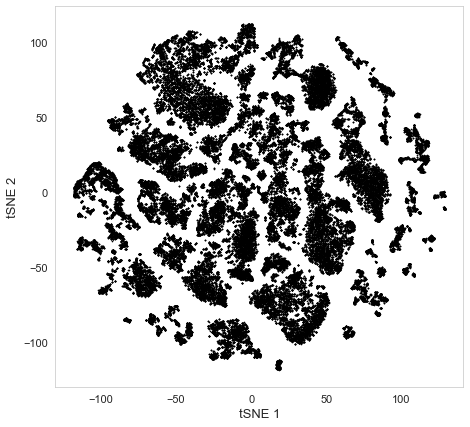

In [73]:
embedding_space_data = pd.read_csv('embedding_space_metrics.csv')

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embedding_space_data.comp_1,embedding_space_data.comp_2,c='k',s=0.5)
# plt.colorbar(scatter)
# plt.title('Swav Embedding t-SNE')
plt.xlabel('tSNE 1', fontsize=13)
plt.ylabel("tSNE 2", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
# plt.savefig("embedding_no_color.svg", format="svg")
plt.show() 

### Ground truth label

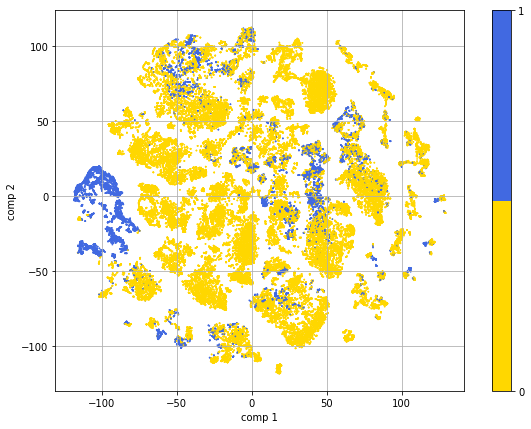

In [9]:
plt.figure(figsize=(10, 7))
cmap = ListedColormap(['gold', 'royalblue'])
scatter = plt.scatter(embedding_space_data.comp_1,embedding_space_data.comp_2,c=embedding_space_data.label,cmap=cmap, s=0.5)
plt.colorbar(scatter, ticks=[0, 1])
# plt.title('Swav Embedding t-SNE')
plt.xlabel('comp 1')
plt.ylabel("comp 2")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

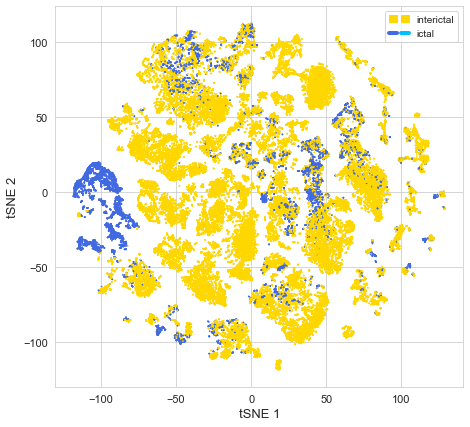

In [79]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple

# Your existing plot code
plt.figure(figsize=(10, 7))
cmap = ListedColormap(['gold', 'royalblue'])
scatter = plt.scatter(embedding_space_data.comp_1, embedding_space_data.comp_2, c=embedding_space_data.label, cmap=cmap, s=0.5)

# Create custom legend
legend_elements = [Patch(facecolor='gold', edgecolor='gold', label='interictal'),
                   Patch(facecolor='royalblue', edgecolor='royalblue', label='ictal')]

legend_elements = [
    (Patch(facecolor='gold', edgecolor='gold'), Patch(facecolor='gold', edgecolor='gold')),
    (Line2D([0], [0], color='royalblue', lw=4), Line2D([0], [0], color='deepskyblue', lw=4))
]

# Labels for the legend elements
labels = ['interictal', 'ictal']
# Add legend to plot
# plt.legend(handles=legend_elements, fontsize=11)

plt.legend(legend_elements, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper right')
# Additional plot formatting
# plt.title('Swav Embedding t-SNE')
plt.xlabel('tSNE 1', fontsize=13)
plt.ylabel("tSNE 2", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig("embedding_with_label_no_grid.svg", format="svg")
# Show plot
plt.show()

## Plotting Examples

In [5]:
def plot_together_kadane(data, importance_score, labels, embedding_space_data, high_light_index):
    # Create a figure with custom space for subplots
    fig = plt.figure(figsize=(18, 8))  # Increased width to accommodate the third plot
    
    # Create a gridspec to manage the layout
    gs = GridSpec(2, 2, width_ratios=[2, 2], height_ratios=[3, 1])

    # Define the axes for the EEG and importance score plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    
    # Plot EEG data
    plot_data_ax(data, ax1, labels=labels)
    
    # Plot importance score
    ax2.plot(np.arange(len(importance_score))/249, importance_score, 'b', label='Importance Score')
    ax2.axhline(y=-0.2, color='k', linestyle='--', label='Threshold')
    ax2.legend()

    # Define the axis for the embedding space heatmap plot
    ax3 = fig.add_subplot(gs[:, 1])

    # Plot the embedding space heatmap
    scatter = ax3.scatter(embedding_space_data['comp_1'], embedding_space_data['comp_2'],
                          c=embedding_space_data['importance_score'], cmap='inferno', s=0.5)
    ax3.scatter(embedding_space_data['comp_1'][high_light_index], embedding_space_data['comp_2'][high_light_index],
            c='limegreen', s=40, edgecolor='black', zorder=3)
    
    fig.colorbar(scatter, ax=ax3)
    ax3.set_xlabel('comp 1')
    ax3.set_ylabel('comp 2')
    ax3.grid()
    
    # Adjust the layout
    plt.tight_layout()
    plt.show()

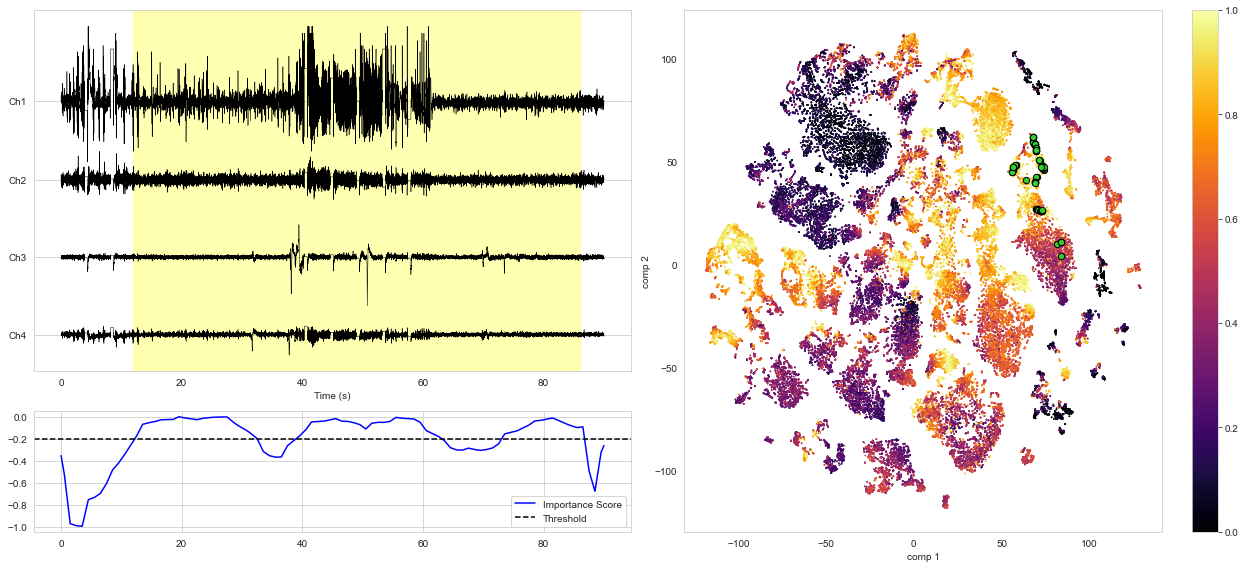

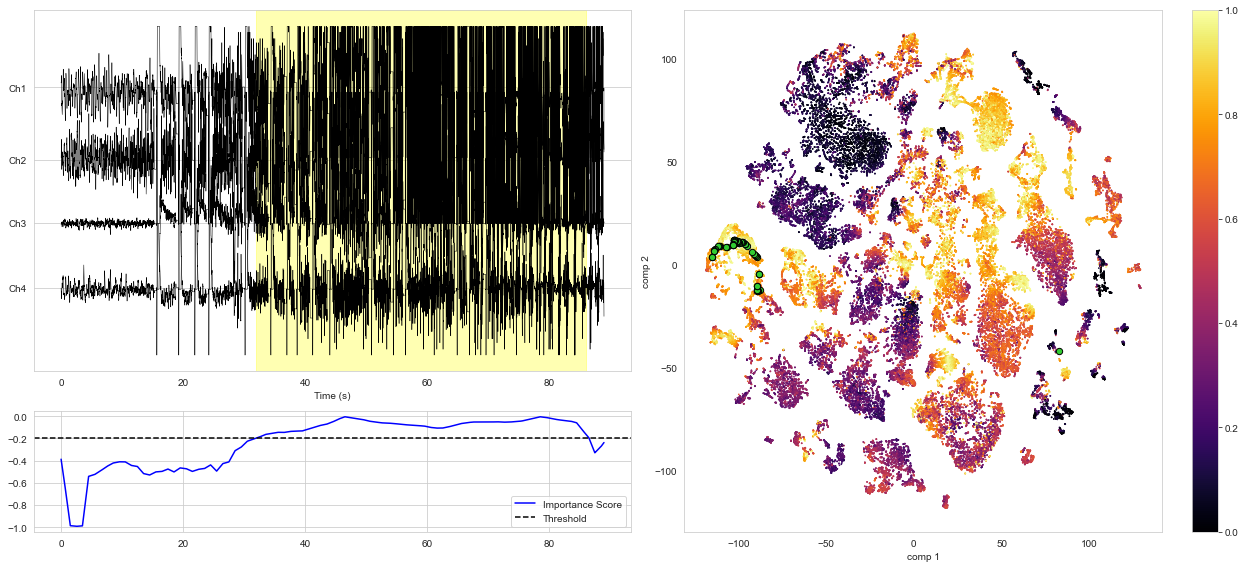

In [7]:
for file_name in ['episode_40_example.csv', 'episode_419_example.csv']:
    example = pd.read_csv(file_name)
    example_data = example[['ch_1', 'ch_2', 'ch_3', 'ch_4']].to_numpy().T
    plot_together_kadane(example_data, example.importance_score, [example.to_select.to_numpy()], embedding_space_data, example[example.to_select == 1].i.unique())

## Prediction Example

In [10]:
def plot_prediction(data, embedding_space_data, index = None, labels=None, dr=0.5):
    color_list = ["yellow", 'royalblue']
    legend_list = ['true_label', 'pred_label']
    n_samples, n_rows = data.shape[1], data.shape[0]
    h, w = n_rows * 2, 10
    y_tick_offsets = (np.arange(n_rows) * dr)[::-1]

    # Define subplot layout
    plt.figure(figsize=(20, h))  # Adjusted width to accommodate both plots

    # Plotting the EEG data
    ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    eeg_data = data + y_tick_offsets[:, np.newaxis]
    time_domain = np.arange(data.shape[1]) / 249
    for i in range(eeg_data.shape[0]):
        ax1.plot(time_domain, eeg_data[i], 'k', linewidth=0.5)
    if labels is not None:
        for j, label in enumerate(labels):
            label_start, label_end = plot_high_light(label)
            for i in range(len(label_start)):
                ax1.axvspan(label_start[i] / 249, label_end[i] / 249, color=color_list[j], alpha=0.3,label = legend_list[j])
    ax1.set_yticks(eeg_data.mean(axis=1))
    ax1.set_yticklabels(["Ch1", "Ch2", "Ch3", "Ch4"])
    ax1.grid(axis='x')
    ax1.set_xlabel('Time (s)')
    ax1.legend()

    # Plotting the embedding space data
    ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    cmap = ListedColormap(['gold', 'royalblue'])
    scatter = ax2.scatter(embedding_space_data['comp_1'], embedding_space_data['comp_2'], 
                          c=embedding_space_data['label'], cmap=cmap, s=0.5)
    if index is not None:
        ax2.scatter(embedding_space_data['comp_1'][index], embedding_space_data['comp_2'][index],
            c='limegreen', s=40, edgecolor='black', zorder=3)
    plt.colorbar(scatter, ticks=[0, 1], ax=ax2)
    ax2.set_xlabel('comp 1')
    ax2.set_ylabel("comp 2")
    ax2.grid()

    plt.show()

### Good Example

C:\Users\Patrick Xu\AppData\Local\Temp\ipykernel_42904\3439332422.py:16: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


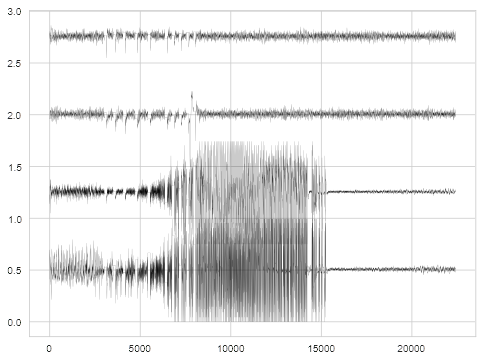

In [30]:
import matplotlib
matplotlib.use('cairo')
example = pd.read_csv('good_example' + '/' + os.listdir('good_example')[0])
example_data = example[['ch_1', 'ch_2', 'ch_3', 'ch_4']].to_numpy().T

example_data = example_data-

dr= 0.75
n_samples, n_rows = example_data.shape[1], example_data.shape[0]
h, w = n_rows * 1.5, 8

y_tick_offsets = (np.arange(n_rows) * dr)[::-1]

plt.figure(figsize=(w, h))

eeg_data = example_data + y_tick_offsets[:, np.newaxis]

plt.plot(eeg_data.T, 'k', linewidth=0.1)
plt.savefig("example_rns.svg", format="svg")
plt.show()



In [ ]:
class RNS_Raw(Dataset):
    def __init__(self, file_names, transform=True, astensor=True):
        self.file_names = file_names
        self.transform = transform

        print('init_loading')
        file_name_temp = self.file_names[0]
        with open(data_dir + 'rns_cache/' + file_name_temp, 'rb') as f:
            temp_file = np.load(f)

        print('loaded first')
        self.data = np.empty((0, temp_file.shape[1], temp_file.shape[2]))
        # print(self.data.shape)

        for name in tqdm(self.file_names):
            with open(data_dir + 'rns_cache/' + name, 'rb') as f:
                cache = np.load(f)
            self.data = np.vstack((self.data, cache))

        print('data loaded')

        self.length = len(self.data)

        if astensor:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
                T.ToTensor()
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.ToTensor()
            ])
        else:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
            ])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        data = self.data[index]

        if self.transform:
            concat_len = data.shape[1] / 4
            channel_index = np.arange(4)
            np.random.shuffle(channel_index)
            channel_index = channel_index * concat_len + (concat_len - 1) / 2
            channel_index = np.repeat(channel_index, concat_len)
            concate_len_1 = (concat_len - 1) / 2
            a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
            base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
            channel_index = channel_index + base_repeat
            data = data[channel_index.astype(int)]
            data = torch.from_numpy(data).clone()
            data = data.repeat(3, 1, 1)
            data = self.augmentation(data)

        else:
            concat_len = data.shape[1] / 4
            channel_index = np.arange(4)
            # np.random.shuffle(channel_index)
            channel_index = channel_index * concat_len + (concat_len - 1) / 2
            channel_index = np.repeat(channel_index, concat_len)
            concate_len_1 = (concat_len - 1) / 2
            a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
            base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
            channel_index = channel_index + base_repeat
            data = data[channel_index.astype(int)]
            data = torch.from_numpy(data).clone()
            data = data.repeat(3, 1, 1)
            data = self.totensor(data)

            # data = torch.from_numpy(data).clone()
            # data = data.repeat(3, 1, 1)
            # data = self.totensor(data)

        return data, [], None

In [ ]:
for file_name in os.listdir('good_example'):
    example = pd.read_csv('good_example' + '/' + file_name)
    example_data = example[['ch_1', 'ch_2', 'ch_3', 'ch_4']].to_numpy().T
    plot_prediction(example_data, embedding_space_data, index= example[example.pred_label == 1].i.unique(), labels=[example.true_label, example.pred_label])

### Bad Example (where the model did not recognize a seizure)

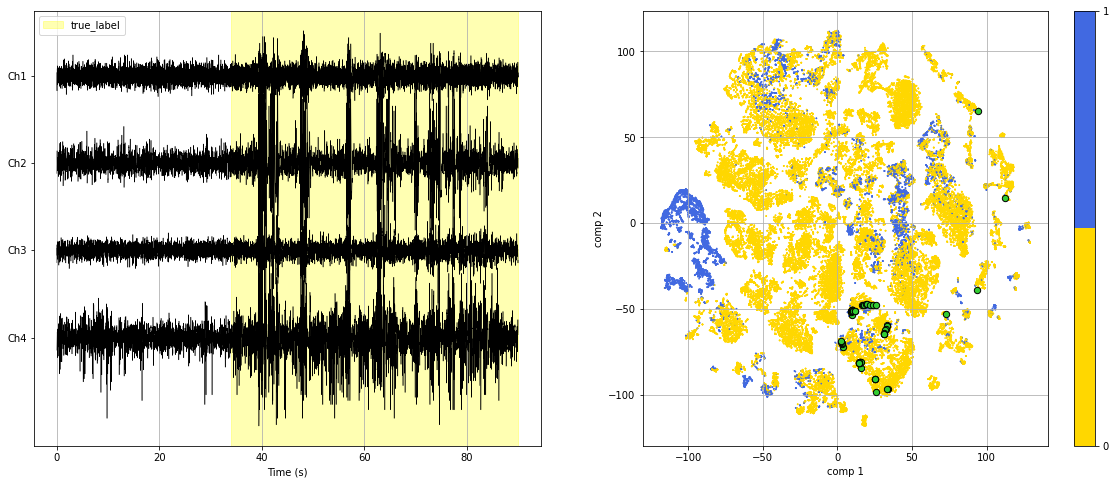

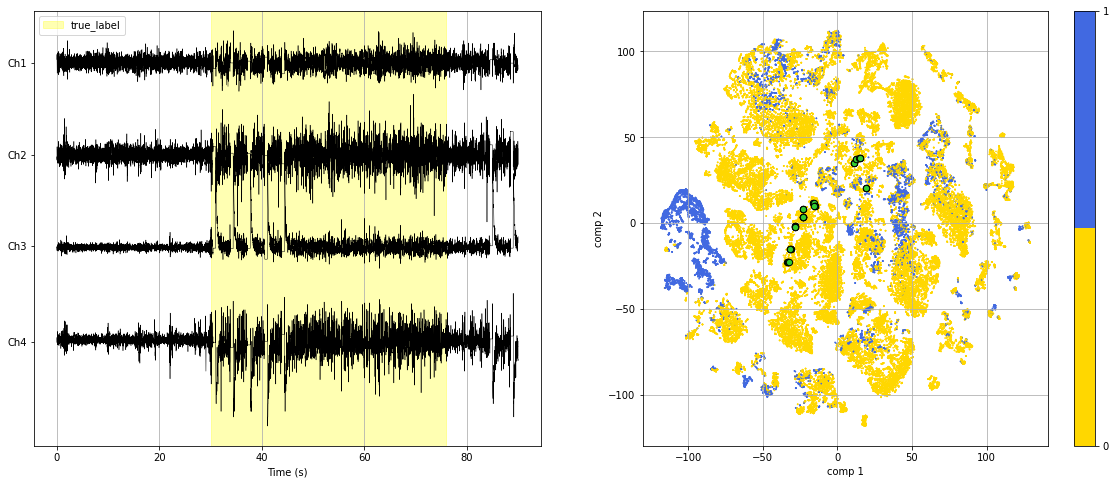

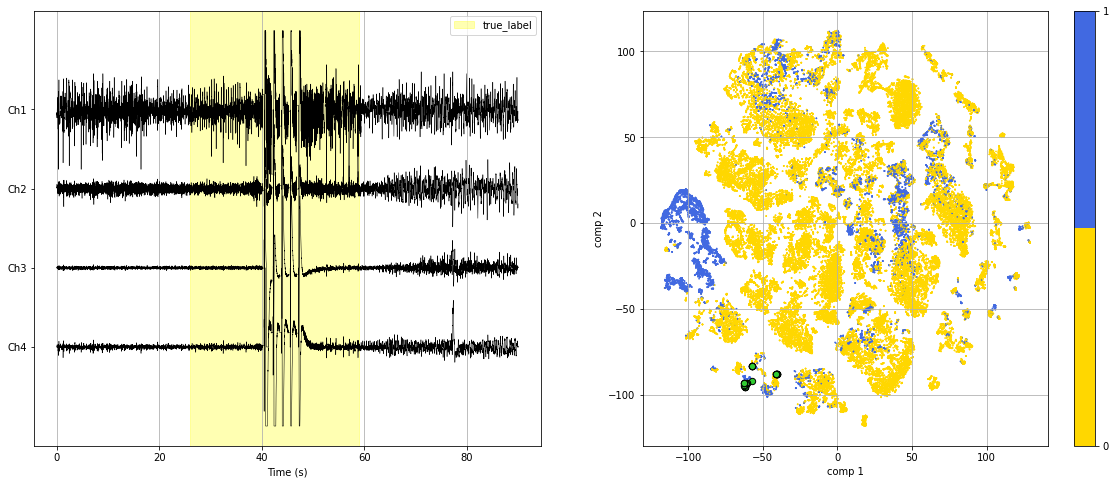

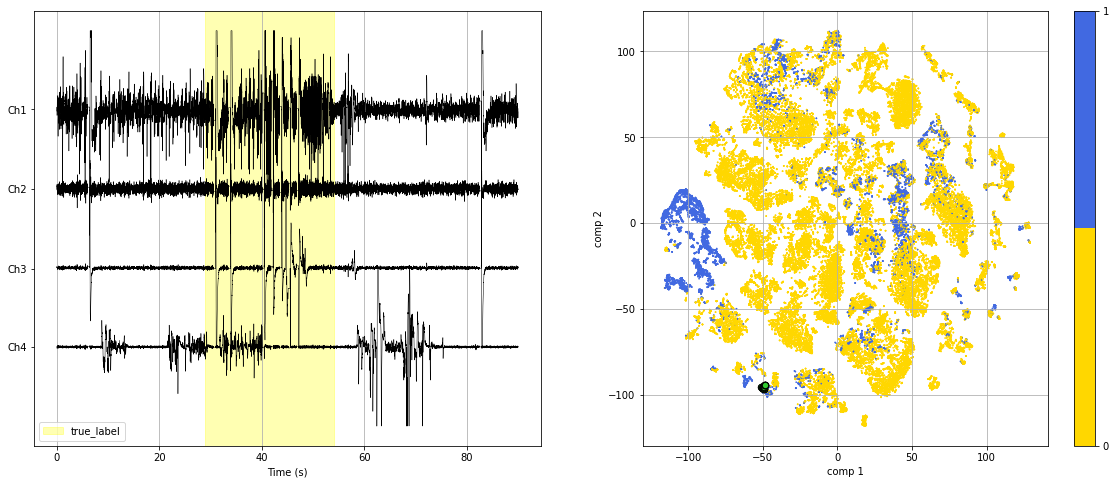

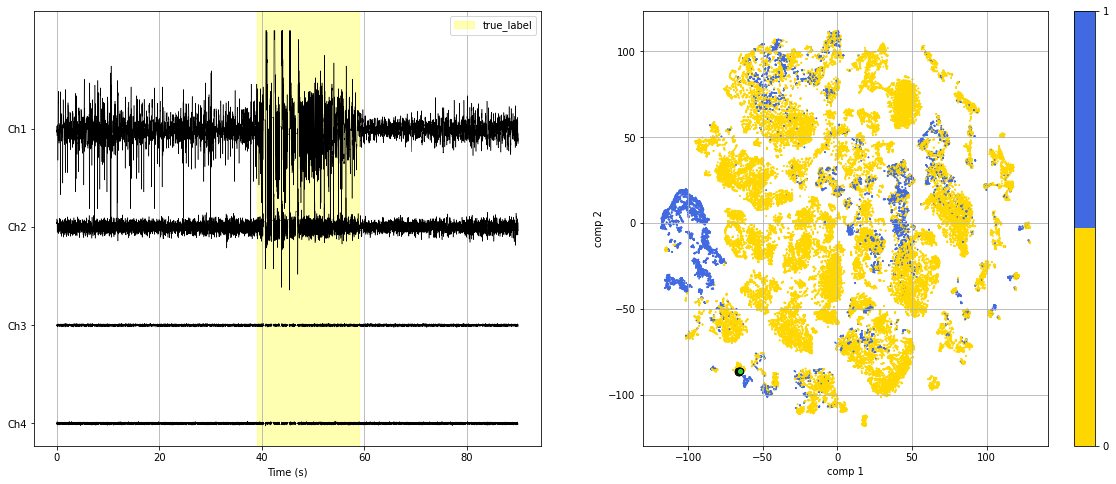

In [12]:
for file_name in os.listdir('bad_example'):
    example = pd.read_csv('bad_example' + '/' + file_name)
    example_data = example[['ch_1', 'ch_2', 'ch_3', 'ch_4']].to_numpy().T
    plot_prediction(example_data, embedding_space_data, index= example[example.true_label == 1].i.unique(), labels=[example.true_label, example.pred_label])